In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import zipfile
path_to_zip_file = "/content/gdrive/MyDrive/AI Project/Dataset3.zip"
directory_to_extract_to = "/content"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from tqdm import tqdm
!pip install optuna

import optuna


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.1 MB/s eta 0:00:00


In [4]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [5]:
output_dir = "/content/flowers/"

In [6]:
dataset=datasets.ImageFolder(root=(output_dir),transform=train_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 15740
    Root location: /content/flowers/
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']
16


In [8]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [9]:
# Define the ResNet18 architecture
class ResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
import optuna
from optuna.visualization import plot_param_importances

In [14]:
# Define the objective function for Optuna
def objective(trial):
    BATCH_SIZE = trial.suggest_categorical('batch_size', [32, 64, 128])
    LR = trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001])
    
    print(f"Now trying batch size with {BATCH_SIZE} and learning rate {LR}.")

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Define the ResNet18 architecture
    model = ResNet18(num_classes = len(class_names)).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train the model
    num_epochs = 10

    for epoch in range(num_epochs):
        # Train the model on the training set
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_dataloader):
            inputs, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the training loss
        train_loss = running_loss / len(train_dataloader)

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in tqdm(val_dataloader):
                inputs, labels = images.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate the validation loss and accuracy
            val_loss = running_loss / len(val_dataloader)
        
        # Report intermediate objective value (validation loss)
        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Return the final validation loss
    return val_loss



In [15]:
# Define the study and run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-04-05 21:40:47,436] A new study created in memory with name: no-name-59dc0e74-65b0-4926-ae72-709a893b35b5


Now trying batch size with 64 and learning rate 0.001.


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]
[I 2023-04-05 21:55:27,074] Trial 0 finished with value: 0.8553578758239746 and parameters: {'batch_size': 64, 'lr': 0.001}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 128 and learning rate 0.001.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
[I 2023-04-05 22:09:57,948] Trial 1 finished with value: 1.1739593469179594 and parameters: {'batch_size': 128, 'lr': 0.001}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 128 and learning rate 0.1.


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
[I 2023-04-05 22:24:22,304] Trial 2 finished with value: 2.7820883714235745 and parameters: {'batch_size': 128, 'lr': 0.1}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 128 and learning rate 0.1.


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
[I 2023-04-05 22:38:49,814] Trial 3 finished with value: 1.9137040101564848 and parameters: {'batch_size': 128, 'lr': 0.1}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 128 and learning rate 0.1.


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
[I 2023-04-05 22:53:19,157] Trial 4 finished with value: 1.7223123220297007 and parameters: {'batch_size': 128, 'lr': 0.1}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 128 and learning rate 0.1.


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
[I 2023-04-05 22:54:47,099] Trial 5 pruned. 


Now trying batch size with 128 and learning rate 0.1.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
[I 2023-04-05 22:56:16,161] Trial 6 pruned. 


Now trying batch size with 128 and learning rate 0.0001.


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
[I 2023-04-05 23:10:56,704] Trial 7 finished with value: 0.8965120269702032 and parameters: {'batch_size': 128, 'lr': 0.0001}. Best is trial 0 with value: 0.8553578758239746.


Now trying batch size with 64 and learning rate 0.0001.


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]
[I 2023-04-05 23:25:53,667] Trial 8 finished with value: 0.8047440934181214 and parameters: {'batch_size': 64, 'lr': 0.0001}. Best is trial 8 with value: 0.8047440934181214.


Now trying batch size with 64 and learning rate 0.1.


100%|██████████| 25/25 [00:07<00:00,  3.15it/s]
[I 2023-04-05 23:27:24,226] Trial 9 pruned. 


In [17]:
# Plot the optimization history
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Plot the hyperparameter importances
fig = plot_param_importances(study)
fig.show()


In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [24]:
fig = optuna.visualization.plot_slice(study)
fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.show()

In [26]:
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Best trial:
  Value: 0.8047440934181214
  Params: 
    batch_size: 64
    lr: 0.0001


In [27]:
best_lr = study.best_params['lr']
best_batch_size = study.best_params['batch_size']

In [28]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

In [29]:
model = ResNet18(num_classes = len(class_names)).to(device)

In [30]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

Now starting epoch: 1
Epoch [1/100], Train Loss: 1.6684, Train Accuracy: 43.83 %
Epoch [1/100], Validation Loss: 1.5018, Validation Accuracy: 49.49 %
Saving model checkpoint...
Now starting epoch: 2
Epoch [2/100], Train Loss: 1.1603, Train Accuracy: 61.33 %
Epoch [2/100], Validation Loss: 1.1496, Validation Accuracy: 62.52 %
Saving model checkpoint...
Now starting epoch: 3
Epoch [3/100], Train Loss: 0.9786, Train Accuracy: 67.44 %
Epoch [3/100], Validation Loss: 0.9683, Validation Accuracy: 68.61 %
Saving model checkpoint...
Now starting epoch: 4
Epoch [4/100], Train Loss: 0.8452, Train Accuracy: 72.05 %
Epoch [4/100], Validation Loss: 0.9432, Validation Accuracy: 68.23 %
Saving model checkpoint...
Now starting epoch: 5
Epoch [5/100], Train Loss: 0.7482, Train Accuracy: 74.73 %
Epoch [5/100], Validation Loss: 0.8595, Validation Accuracy: 71.47 %
Saving model checkpoint...
Now starting epoch: 6
Epoch [6/100], Train Loss: 0.6798, Train Accuracy: 77.25 %
Epoch [6/100], Validation Loss: 0.

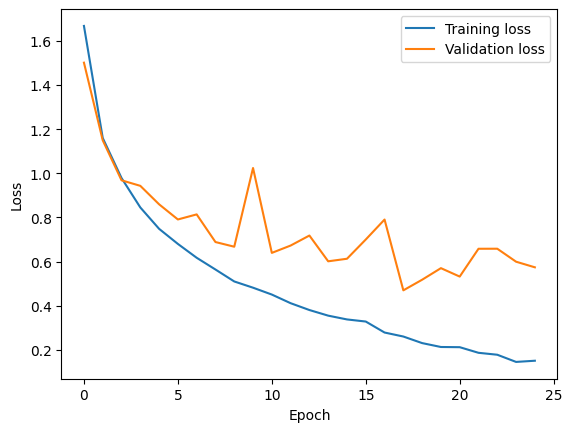

In [31]:
# Train the model
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 7  # number of epochs to wait for improvement
metrics = []


for epoch in range(num_epochs):
    print(f"Now starting epoch: {epoch+1}")
    # Train the model on the training set

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate the training loss
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    #print('Epoch [%d/%d], Train Loss: %.4f' % (epoch+1, num_epochs, train_loss))
    print('Epoch [%d/%d], Train Loss: %.4f, Train Accuracy: %.2f %%' % (epoch+1, num_epochs, train_loss, train_accuracy))

    """model.train()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the training loss and accuracy
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        print('Epoch [%d/%d], Train Loss: %.4f, Train Accuracy: %.2f %%' % (epoch+1, num_epochs, train_loss, train_accuracy))"""

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataloader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        print('Epoch [%d/%d], Validation Loss: %.4f, Validation Accuracy: %.2f %%' % (epoch+1, num_epochs, val_loss, val_accuracy))
        metrics.append([epoch+1,train_loss,val_loss,train_accuracy,val_accuracy])

        
        # Checkpoint the model if the validation loss has improved (Early stopping)
        if val_loss < best_val_loss:
            print("Saving model checkpoint...")
            best_val_loss = val_loss
            checkpoint = {'epoch': epoch+1,
                          'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                          'train_loss': train_loss,
                          'val_loss': val_loss}
            torch.save(checkpoint, 'model_checkpoint.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience left: {patience - patience_counter}")
            if patience_counter >= patience:
                print("Stopping training due to early stopping...")
                break
        
    # Switch the model back to training mode
    model.train()

print('Finished Training')

# Plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
best_checkpoint = torch.load('/content/model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])

dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [33]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate the test loss and accuracy
    test_loss = running_loss / len(test_dataloader)
    test_accuracy = 100 * correct / total
    print('Test Loss: %.4f, Test Accuracy: %.2f %%' % (test_loss, test_accuracy))

Test Loss: 0.5135, Test Accuracy: 83.51 %


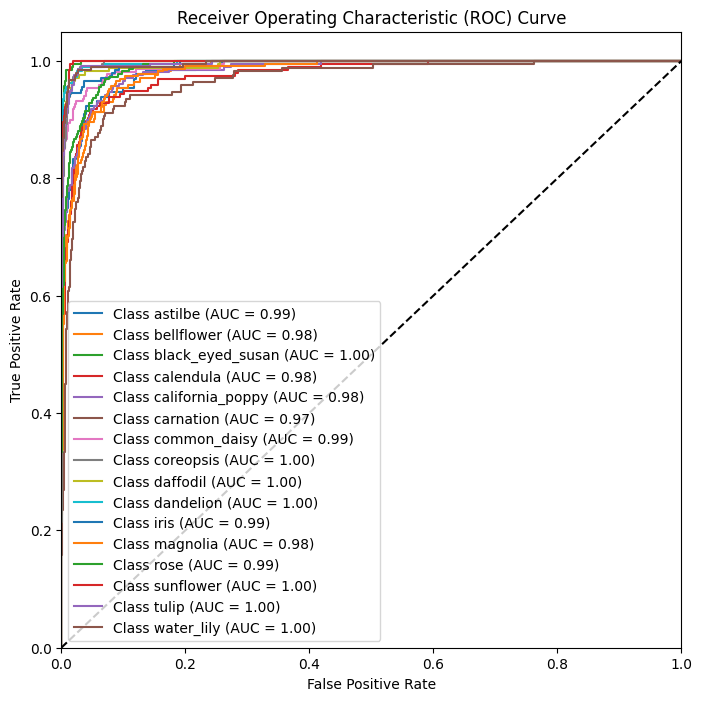

In [34]:
# Calculate the ROC curve and AUC for each class
#model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    all_labels = []
    all_probs = []
    true_labels = []
    pred_labels = []
    all_preds = []
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = %.2f)' % (roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

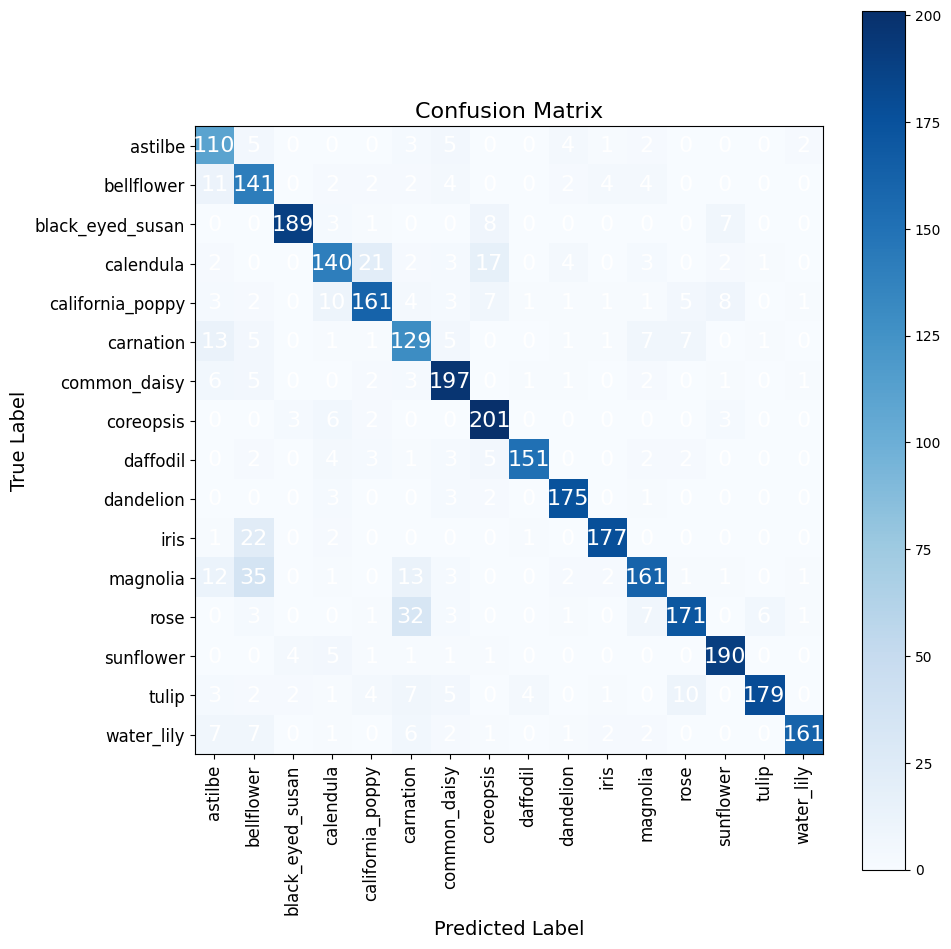

In [35]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
# Plot the confusion matrix with label names
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Add the values to the cells of the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
plt.show()

In [36]:
# Generate the classification report
target_names = class_names
print(classification_report(all_labels, all_preds, target_names=target_names))

                  precision    recall  f1-score   support

         astilbe       0.65      0.83      0.73       132
      bellflower       0.62      0.82      0.70       172
black_eyed_susan       0.95      0.91      0.93       208
       calendula       0.78      0.72      0.75       195
california_poppy       0.81      0.77      0.79       208
       carnation       0.64      0.75      0.69       171
    common_daisy       0.83      0.90      0.86       219
       coreopsis       0.83      0.93      0.88       215
        daffodil       0.96      0.87      0.91       173
       dandelion       0.91      0.95      0.93       184
            iris       0.94      0.87      0.90       203
        magnolia       0.84      0.69      0.76       232
            rose       0.87      0.76      0.81       225
       sunflower       0.90      0.94      0.92       203
           tulip       0.96      0.82      0.88       218
      water_lily       0.96      0.85      0.90       190

        accu

In [37]:
# Calculate and print the precision, recall, accuracy, and F1-score
precision = sum([cm[i, i] / sum(cm[:, i]) for i in range(len(target_names))]) / len(target_names)
recall = sum([cm[i, i] / sum(cm[i, :]) for i in range(len(target_names))]) / len(target_names)
accuracy = sum([cm[i, i] for i in range(len(target_names))]) / np.sum(cm)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-score: {:.2f}%'.format(f1_score * 100))

Precision: 84.04%
Recall: 83.73%
Accuracy: 83.64%
F1-score: 83.88%


In [38]:
#Saving metrics for plotting future
metrics_as_numpy = np.array(metrics)

# Save the NumPy array to a file
np.save('Dataset3_optimized_Resnet_metrics.npy', metrics_as_numpy)